# Predicting Qualification into Golf Ontario's Men's Mid-Amateur Championship
**Author: Adrian Mazzarolo**<br>
**Date: February 2026**<br>

***

This analysis investigates how score, weather conditions, and provincial region affect a player's likelihood of qualifying for the Ontario Men's Mid-Amateur Championship; an event hosted each year for male golfers aged 25+ with eligible Golf Canada handicaps of 7.5 or lower.

## Executive Summary

1. Question
    1. What score do I need to shoot to qualify?
2. Method
    1. Logistic Regression
        1. To Par
        2. To Course Rating
3. Key Findings
    1. If you shoot under par you have a 100% chance of qualifying; Over +10, you have a 0% chance
    2. Scores within +2 of Course Rating have >90% chance of qualifying
    3. Scores of +7 or above relative to Course Rating have < 6% chance
    4. Most fragile region is between +2.5 to +5.5. Each dropped shot costs about 20% chance.
4. So What
    1. Aside from being a fun exercise, this model provides high-level amateurs with some expectation of required scores to qualify for the Ontario Men's Mid-Am. Although it may not be recommended to "play to a score", it could aid in strategic decision-making during the final few holes. For example, knowing an extra shot could bring 20% difference in probability, do you play aggressive, or play it safe?
    2. Could also set expectations for whether someone should enter a qualifier. If you don't seriously believe you can shoot a score in the 70s in tournament conditions, maybe return when you feel you can.
5. Next Steps / Limitations
    1. Similar to above, instead of full round probability could look at intra-round probabilities.
    2. Could analyze player-specific data to assess impact on qualification (handicap, recent rounds, prior qualification attempts)
    3. Inter-championship analyses

## A Data Scientist from Day One

Growing up playing competitive junior golf, I recall the frequent advice of "don't play to a specific score". Golf is a cruel game. One day you 75 might be "good enough", another day you've been beat by 10. Instead of worrying about a "golden number", I was advised to play as best as I could and see where it landed when all was said and done.<br>

While I completely understood this logic, and still do, as an analytical person it wasn't always easy for me to follow. Before a tournament or qualifier, I would look at historical results to see what would realistically be needed to achieve my goal for that event, be it winning or qualifying. At registration tables my mind would race as I saw the glaring **'THERE WILL BE __ QUALIFICATION SPOTS'** number in front of me. What percentage of players would qualify based on that number of spots? If I look outside and its raining and windy, should I smile like [Jack Nicklaus](https://www.golfdigest.com/story/golf-sh-t-conditions-good-for-you) used to since my chances were likely higher if I could stick it out? Thankfully, I was able to put most of these thoughts aside before my first tee shot, often to middling success, but the desire to predict what constituted a "good score" never ceased. Even to this day.<br>

With the recent release of Golf Ontario's [competitive schedule for 2026](https://www.golfontario.ca/2026-competitive-schedule/), I figured it a great time to scratch that predictive itch once again; however, this time I would apply more robust statistical methods in doing so.<br>

At the heart of this analysis lies a single question:<br>
**"What does a player need to shoot to have a high chance of qualifying for the Ontario Men's Mid-Am?".**

While this may appear overly simplistic on the surface, it comes with a plethora of supporting questions, such as:
* Does the number of competitors impact one's chances of qualifying? What about the number of qualifying spots?
* If weather is calm, how much better does one have to play to qualify? What if the weather is severe?
* Is there an advantage to entering a qualifier in more "remote" regions?

Considering Golf Ontario's qualifiers host many of province's best golfers, margins are incredibly thin in competition. If any of these suplementary factors could make the difference of even a single stroke it could be the difference between qualifying and not. While again, common advice overwhelmingly says to not focus on other's scores, some of us clearly can't help ourselves. 

## Data Introduction and Exploratory Analysis

To provide a robust enough sample size, my analysis utilizes data from **25 qualifiers between the 2023 and 2025 seasons**, totalling **over 1,400 individual scores**.<br>

The data is divided into two datasets; one including **event information** and another including the **individual scores**. This section includes a description of each, including various exploratory analyses and data cleaning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import patsy
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from matplotlib.ticker import MultipleLocator

sns.set_style('darkgrid')

### Events Data
The events dataset includes a user-generated event ID for each qualifier, as well as some other useful information including:
- Qualifer Course
- Date of Qualifier
- Weather Data
    - Average Temperature (˚C)
    - Average Wind Gusts (km/h)
    - Total Rainfall (mm)
- Number of Qualifying Spots
- Field Size (Number of Players)
- Course Difficulty Data
    - Course Rating
    - Course Slope
- Location Data
    - Latitude
    - Longitude

A preview of this dataset, as well as a map of where events were hosted, can be found below.

**Where necessary, this section elaborates on key data points, including i) Field Sizes and Qualifying Spots, ii) Weather Data, and iii) Course Difficulty Data.**

<u>A Note on Sources</u><br>
Event- / course-specific information such as date, field size, and difficulty was sourced from each qualifier's unique Golf Ontario GolfGenius site, such as [this example](https://www.golfgenius.com/pages/11289234315877075432). Historical weather data was sourced from [Open-Meteo's Weather API](https://open-meteo.com/en/docs/historical-weather-api).

In [2]:
events = pd.read_excel('/Users/adrianmazzarolo/Library/CloudStorage/OneDrive-Personal/Golf Ontario Qualifying Analysis.xlsx',
                       sheet_name='Events').set_index('Event ID').sort_index()
events.head()

,Qualifier Course,Date,Mean Temperature (Celcius),Mean Wind Gusts (km/h),Rain Sum (mm),Qualifying Spots,Field Size,Rating,Slope,Latitude,Longitude
Event ID,,,,,,,,,,,
1,Sarnia G&CC,2025-04-29,17.9,51.7,0.9,10,45,71.6,127,42.991456,-82.395360
2,Cobble Beach GL,2025-05-12,13.4,23.5,0.0,13,63,70.9,126,44.691215,-80.922446
3,Essex G&CC,2025-05-12,16.2,17.5,0.4,12,71,71.7,137,42.219854,-83.080018
4,Toronto GC,2025-05-12,14.7,16.3,0.0,15,78,73.7,141,43.590292,-79.558779
5,Kawartha GC,2025-05-20,9.0,21.9,0.0,15,78,71.5,137,44.286951,-78.357116


In [3]:
m = folium.Map(location=[44.5,-79.5],zoom_start=7)

for row in range(events.shape[0]):
    coords = (events['Latitude'].iloc[row], events['Longitude'].iloc[row])
    folium.Marker(coords, popup=events['Qualifier Course'].iloc[row]).add_to(m)
m

#### Field Sizes and Qualifying Rates

A "Qualifying Rate" variable was created to simplify the Field Size and Qualifying Spots variables into one, summarized data point. 

***What is Golf Ontario's policy on the number of qualifiers per site?***

As per [this BlueGolf webpage](https://gao.bluegolf.com/bluegolfw/gao/mo/AQ_Spots_Explained.htm), Golf Ontario uses a spot formula to determine the number of qualifiers for a given site. **Without explicit confirmation from Golf Ontario**, the policy reads that each site is given a proportionate number of qualifying spots based on how much of the total player base their site has after considering exemptions. See below for a mathematical representation of this formula:<br>

$$\text{Site ABC Qualifying Spots} = \frac{\text{Players At Site ABC}}{\text{Total Players Across All Sites}} * \text{ Total Championship Qualifying Spots}$$

For example, if there are 500 players vying for 100 spots in the Mid-Am and Site A has 50 players registered, they would get 10 qualifying spots.<br> 
$$\frac{50}{500} * 100 = 10 \text{ Qualifying Spots}$$

In [4]:
events['Qualifying Rate (%)'] = (events['Qualifying Spots'] / events['Field Size'])*100

The visual below (left) highlights this policy in action, with larger fields earning greater qualifying spots. With that being said, where one would expect a uniform qualifying rate, some events with similar field sizes received slightly different qualifying spots (below right). Unfortunately, there are only so many qualifying spots to extend, meaning some sites may receive one less than the theoretical formula would extend them. Without knowing the full details, I assume these decisions are not made lightly by the organizing parties and are considered in future qualifying spot decisions.

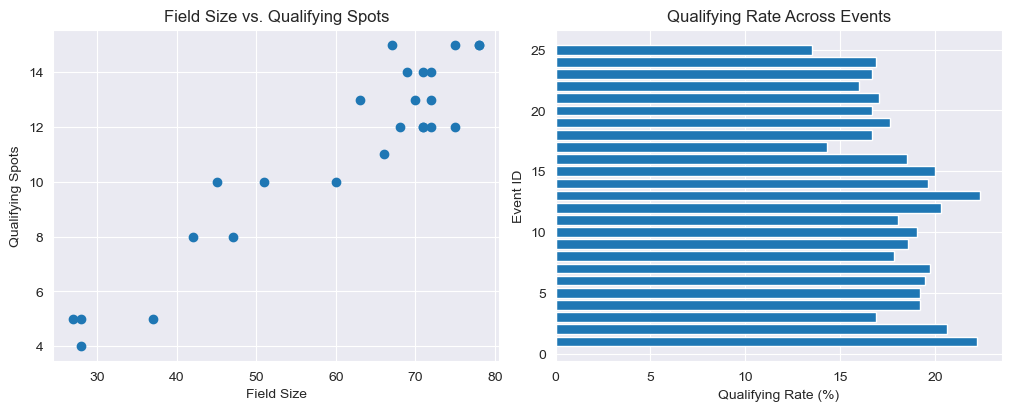

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (10,4), layout='constrained')

axs[0].scatter(data=events, x='Field Size', y='Qualifying Spots')
axs[0].set_title('Field Size vs. Qualifying Spots')
axs[0].set_xlabel('Field Size')
axs[0].set_ylabel('Qualifying Spots')

axs[1].barh(data=events, y=events.index, width='Qualifying Rate (%)')
axs[1].set_title('Qualifying Rate Across Events')
axs[1].set_ylabel('Event ID')
axs[1].set_xlabel('Qualifying Rate (%)');

Interestingly, while the median field size (the middle line within the box and whisker plots below) appears similar across seasons, the median qualifying rate has increased slightly. On a per-qualifier event, this increase is equivalent to roughly one extra spot. Understanding the policy stated above, this increase in qualifying rate may be caused by fewer exemptions, leaving more spots available to open qualification. Considering there is typically 6-8 Mid-Am qualifiers each year, **reduced exemptions does slightly improve accessibility to competitive Ontario golfers.**

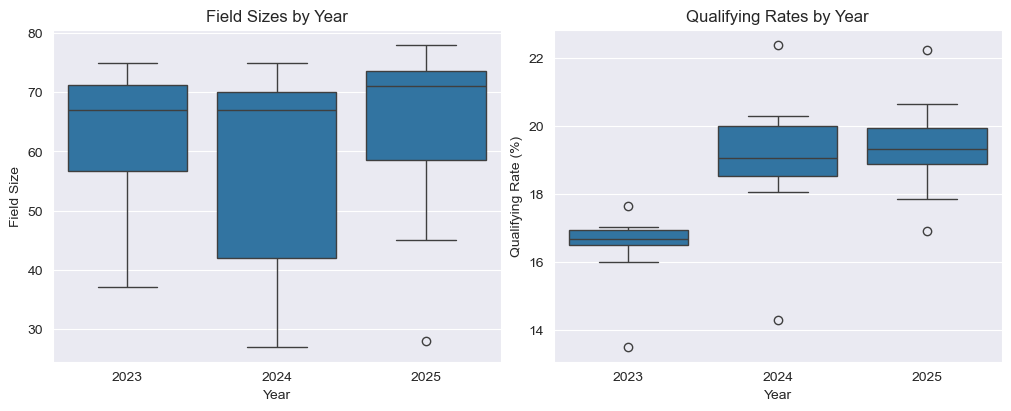

In [6]:
qrs_annual = pd.concat([events['Qualifier Course'],events['Date'].dt.year, events['Qualifying Rate (%)']], axis=1)

fig, axs = plt.subplots(1, 2, figsize = (10,4), layout='constrained')

ax = sns.boxplot(x=events['Date'].dt.year, y=events['Field Size'], ax=axs[0])
ax.set_title('Field Sizes by Year')
ax.set_ylabel('Field Size')
ax.set_xlabel('Year')

ax = sns.boxplot(data=qrs_annual, x='Date', y='Qualifying Rate (%)', ax=axs[1])
ax.set_title('Qualifying Rates by Year')
ax.set_ylabel('Qualifying Rate (%)')
ax.set_xlabel('Year');

In [7]:
# Drop Field Size and Qualifying Rate as we don't need anymore
events = events.drop(['Qualifying Spots', 'Field Size'], axis=1)

#### Weather Severity

Understanding the significant impact weather can play on golfing conditions, historical site-specific data was generated for all 25 events.

As shown below, mean temperatures varied from a brisk 9˚C to comfortable 20˚C, while mean wind gusts ranged from a relatively calm 13 km/h to near gale force winds of 52 km/h. Most qualifiers saw no rain, while some received > 5mm, including Mystic Golf Club in 2024 who recieved 37mm. Interestingly, this is the same event that had near gale force winds, and one that the author had the pleasure of teeing it up in!

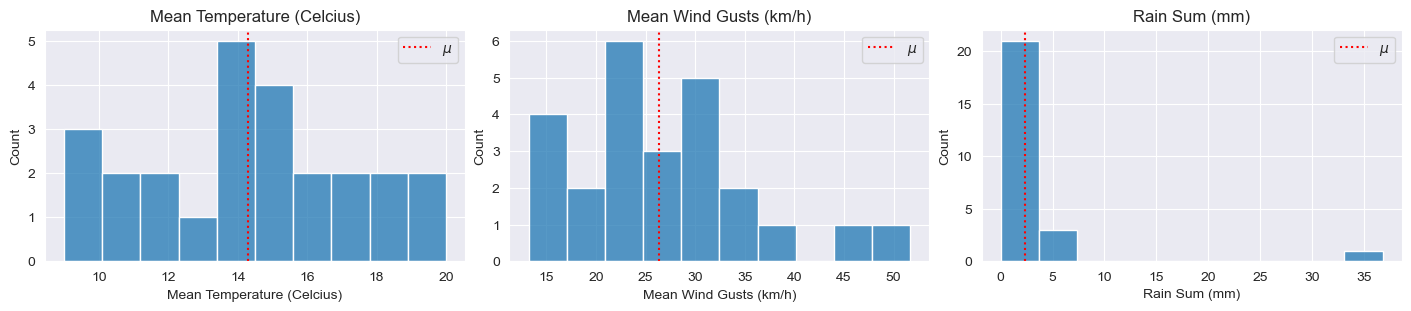

In [8]:
weather_cols = ['Mean Temperature (Celcius)', 'Mean Wind Gusts (km/h)', 'Rain Sum (mm)']
fig, axs = plt.subplots(1, 3, figsize=(14,3), layout='constrained')

for ax, col in enumerate(weather_cols):
    sns.histplot(data=events, x=col, bins=10, ax=axs[ax])
    axs[ax].axvline(events[col].mean(), c='red', ls=':', label=r'$\mu$')
    axs[ax].set_title(f'{col}')
    axs[ax].legend();

To simplify these three data points into a single variable, I categorized each event based on their "adverse weather severity".

The following criteria were used to determine what qualified weather events as "adverse" due to their affect on play:
* **Cold Temperatures:** Average of 10˚C or below
* **High Winds:** Average of 30 km/h or greater
* **Large Rainfall:** Total of 6mm or more

Based on the number of adverse weather events, each event was categorized by severity:
* **Low Severity:** Zero
* **Medium Severity:** One
* **High Severity:** Two or more

Another way of observing weather data is using box and whisker plots, highlighting key values for each variable within a box, including the 25th, 50th (median), and 75th percentile. The "whiskers" below signify the 10th and 90th percentile, meaning values below and above these whiskers fall into the bottom 10% and top 10% overall (marked as outliers using empty circles). Typically, these whiskers are presented in a slightly different fashion, but I believe this method is more insightful for my analysis.

As shown below, most of the "severe weather" criteria values fall within the 10th or 90th percentile of qualifier events, further supporting the aforementioned classification methodology. While 30 km/h winds were closer to being top 20% rather than 10% in historical events, this is the level of wind that I believe starts to significantly affect play and was therefore used as the classification cutoff.

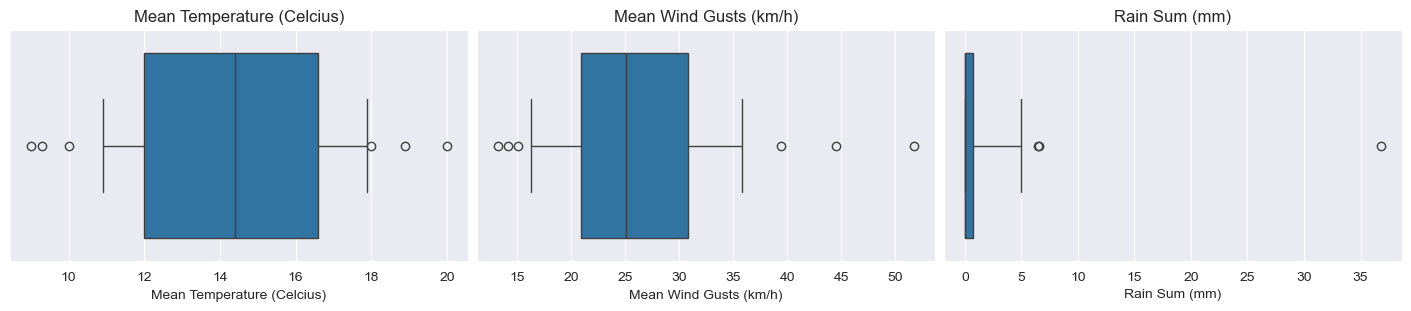

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(14,3), layout='constrained')

for ax, col in enumerate(weather_cols):
    sns.boxplot(data=events, x=col, ax=axs[ax], whis=[10,90])
    axs[ax].set_title(f'{col}')

In [10]:
events['Adverse Weather Events'] = pd.concat([events['Mean Temperature (Celcius)']<=10, 
                                              events['Mean Wind Gusts (km/h)'] >= 30, 
                                              events['Rain Sum (mm)'] > 5], axis=1).sum(axis=1)

weather_severity = {0: 'Low', 1: 'Medium', 2: 'High'}
events['Weather Severity'] = events['Adverse Weather Events'].map(weather_severity)

A preview of the dataset with this summarized variable can be seen below:

In [11]:
events.head(15)

,Qualifier Course,Date,Mean Temperature (Celcius),Mean Wind Gusts (km/h),Rain Sum (mm),Rating,Slope,Latitude,Longitude,Qualifying Rate (%),Adverse Weather Events,Weather Severity
Event ID,,,,,,,,,,,,
1,Sarnia G&CC,2025-04-29,17.9,51.7,0.9,71.6,127,42.991456,-82.395360,22.222222,1,Medium
2,Cobble Beach GL,2025-05-12,13.4,23.5,0.0,70.9,126,44.691215,-80.922446,20.634921,0,Low
3,Essex G&CC,2025-05-12,16.2,17.5,0.4,71.7,137,42.219854,-83.080018,16.901408,0,Low
4,Toronto GC,2025-05-12,14.7,16.3,0.0,73.7,141,43.590292,-79.558779,19.230769,0,Low
5,Kawartha GC,2025-05-20,9.0,21.9,0.0,71.5,137,44.286951,-78.357116,19.230769,1,Medium
6,Mystic GC,2025-05-26,13.1,14.1,0.1,72.4,135,43.210648,-80.066711,19.444444,0,Low
7,Craigowan GC,2025-05-28,12.0,30.1,6.6,72.1,130,43.168925,-80.780057,19.718310,2,High
8,Idylwylde G&CC,2025-06-07,17.7,24.2,0.0,71.8,135,46.464762,-80.986497,17.857143,0,Low
9,Glendale GC,2024-05-09,10.9,21.3,0.0,70.5,128,43.210142,-79.798546,18.571429,0,Low


In [12]:
# Now we can remove data we don't need since we've classified them accordingly.
events = events.drop(['Mean Temperature (Celcius)', 'Mean Wind Gusts (km/h)', 'Rain Sum (mm)', 'Adverse Weather Events'], axis=1)

#### Regional Data

The next important information related to qualifier location. To assess whether regionality could affect qualification chances, each qualifier was categorized into one of four author-generated regions of Ontario:
* **West** - Events west of Brantford (incl. Craigowan, FireRock, Sarnia, and Essex)
* **Central** - Greater Toronto and Hamilton Area ("GTHA") (incl. Mystic, Glendale, Toronto, and Donalda)
* **North** - Northwest of the GTHA (incl. Tangle Creek, Blue Mountain, Cobble Beach, Idylwylde, and Huron Pines)
* **East** - East of Oshawa (incl. Kawartha, Wildfire, Black Bear Ridge, Cataraqui, and Greensmere)

A map below displays each qualifier, coloured based on their region.

From this visual, it appears clear that Golf Ontario has made great efforts to "meet players where they are at" in terms of the locations of their qualifiers.

In [13]:
events['Region'] = pd.Series()

def assign_region(row):
    if row['Latitude'] < 43.17 and row['Longitude'] < -80.77:
        return 'West'
    elif row['Latitude'] > 44.30 and row['Longitude'] < -79.77:
        return 'North'
    elif row['Latitude'] > 43.75 and row['Longitude'] > -79.34:
        return 'East'
    else:
        return 'Central'

events['Region'] = events.apply(assign_region, axis=1)

In [14]:
m = folium.Map(location=[44.5,-79.5],zoom_start=7)

color_map = {
    'West': 'purple',
    'East': 'red',
    'North': 'green',
    'Central': 'darkblue'
}

for index, row in events.iterrows():

    popup_content = f'Course: {row['Qualifier Course']}<br><br>Region: {row['Region']}'
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_content,
        icon=folium.Icon(color=color_map[row['Region']])
    ).add_to(m)
m

### Scores Data

With a strong understanding of the events data, we'll now observe the scores data, which includes each individual golfer's finishing position, score to par, total score, the outcome of their attempt, and the unique event they played in (the same IDs from the events dataset). A preview of this data can be found below:

In [15]:
scores = pd.read_excel('/Users/adrianmazzarolo/Library/CloudStorage/OneDrive-Personal/Golf Ontario Qualifying Analysis.xlsx',
                       sheet_name='Scores')
scores.head(15)

,Pos.,To Par,Total,Outcome,Event ID
0,1,-1,71,Qualified,1
1,2,0,72,Qualified,1
2,3,1,73,Qualified,1
3,3,1,73,Qualified,1
4,5,3,75,Qualified,1
5,5,3,75,Qualified,1
6,7,4,76,Qualified,1
7,7,4,76,Qualified,1
8,7,4,76,Qualified,1
9,10,5,77,Qualified,1


Readers may notice how some golfers shot the same score as a qualifying player, but were instead deemed an "alternate" or "cut". This is a tiebreaking concept known as **retrogression**. More detail on Golf Ontario's retrogression policy can be found [here](https://dsnghfigvjb6s.cloudfront.net/app/uploads/2023/04/2023-GO-Tournament-Policies-Apr-13-2023-1681403734.pdf), but to summarize, if there is a tie after 18 holes of play, the player with the best back nine score would qualify. If tying players had the same back nine score, the process then examines the best back six hole score, then best back three holes, then best final hole score. If somehow, the players are still tied, the process would then go sequentially from the 17th hole to the 1st hole until one player has a better score. 

While opinions differ surrounding retrogression's use, this process allows for much simpler logistical planning for tournament organizers, including those who have already spent countless hours preparing and working each qualifier. Without it, a playoff for the final spot in an event could theoretically run out of daylight - A suboptimal solution considering many players may have used vacation days to attend the qualifier in the first place.<br>

**To incorporate event information into the exploratory data analysis and cleaning for the score data, the two datasets were merged into one:**

In [16]:
scores = scores.merge(right=events, how='left', on='Event ID')
scores.head(15)

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Rating,Slope,Latitude,Longitude,Qualifying Rate (%),Weather Severity,Region
0,1,-1,71,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
1,2,0,72,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
2,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
3,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
4,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
5,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
6,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
7,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
8,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West
9,10,5,77,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,42.991456,-82.39536,22.222222,Medium,West


#### Difficulty Data (Course Rating and Slope Rating)
While many understand par to be the benchmark in which golfers judge themselves, this metric only indicates a player's performance on a specific course. Instead, two other metrics exist that provide a consistent benchmark across courses of all shapes and sizes. These are the **Course Rating** and the **Slope Rating**, with explanations for each below.

**Course Rating -** An indication of the difficulty of a golf course for a scratch golfer (0.0 handicap). Answers the question "What would a scratch player typically shoot on this course during normal weather conditions?". For example, if a course's par is 72, but the Course Rating is 73.8, a scratch player would expect to shoot closer to 74 (+2) rather than 72.

**Slope Rating -** Another indication of difficulty, but represents the relative difficulty for non-scratch players compared to scratch players. The higher the Slope Rating, the more difficult the course is for non-scratch players relative to scratch players.

For more information on both, check out this helpful [link](https://www.usga.org/content/usga/home-page/articles/2024/10/course-rating-vs-slope-rating.html) from the USGA; the organization who created these metrics.

Understanding these ratings, we can now examine player performance through a more standardized lens. For example, say Player A and Player B both shoot 75 (+3) at two different qualifiers; Player A's qualifying site has a Course Rating of 74.5, while Player B's is 73.5. With this, we can that after considering course difficulty, Player A outperformed Player B by a shot, even if they technically shot the same score. 

With this information, we can normalize performance across qualifying sites by taking each player's score and subtracting their site's Course Rating to get a "To Rating" value. Doing this provides an even more nuanced view of what "score" it takes to qualify. Appreciating the handicap eligibility requirement for the Men's Mid-Am being 7.5 or lower as of registration, the Course Rating value was used in this analysis rather than the Slope Rating.

In [17]:
scores['To Rating'] = scores['Total'] - scores['Rating']
scores = scores.drop(['Latitude', 'Longitude'], axis=1)
scores.head(15)

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Rating,Slope,Qualifying Rate (%),Weather Severity,Region,To Rating
0,1,-1,71,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,-0.6
1,2,0,72,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,0.4
2,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4
3,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4
4,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4
5,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4
6,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4
7,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4
8,7,4,76,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,4.4
9,10,5,77,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,5.4


The visuals below display the distributions of players scores across the three main scoring metrics:
* Total Score (Ex. 68, 75, 80)
* Score to Par (Ex. -4, +3, +8)
* Score to Course Rating (Ex. -3.6, +3.4, +8.4)

As shown, total scores were normally distributed around an average of 81, with roughly 45% falling between 76 and 82, and just 4% at 72 or better. When considering these scores relative to par and course rating, most were around +9, with approximately 35% between +6 to +10, and only about 2% under par.

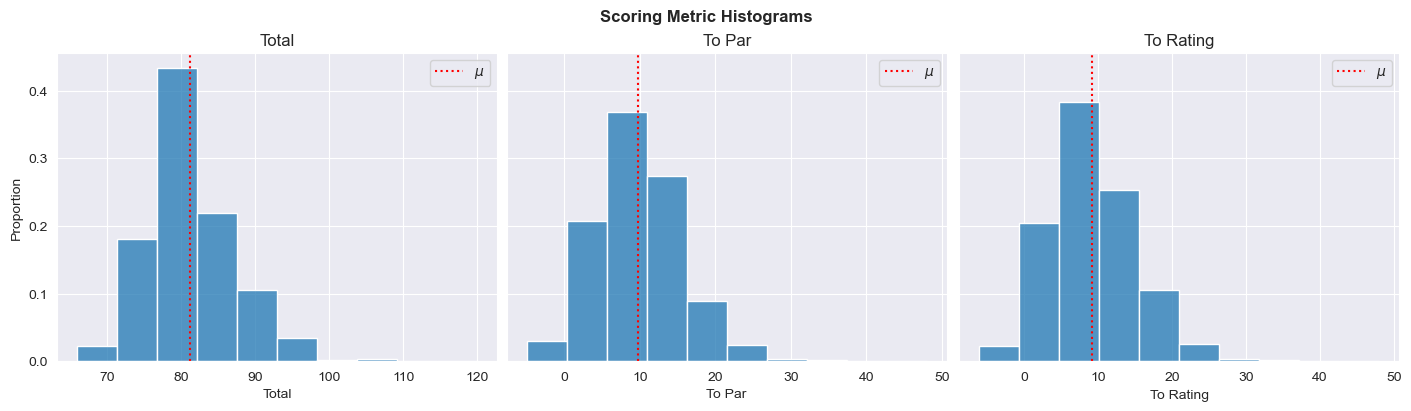

In [18]:
cols = ['Total', 'To Par', 'To Rating']
fig, axs = plt.subplots(1, 3, figsize=(14, 4), layout='constrained', sharey=True)

fig.suptitle('Scoring Metric Histograms', fontweight='bold')

for ax, col in enumerate(cols):
    sns.histplot(scores, x=col, bins=10, ax=axs[ax], stat='proportion')
    axs[ax].axvline(scores[col].mean(), c='red', ls=':', label=r'$\mu$')
    axs[ax].set_title(col)
    axs[ax].legend();

The box and whisker plots below are similar to those used to assess the weather data, but utilize the 5th and 95th percentile rather than 10th and 90th percentile.

Interestingly, for a championship with the aforementioned handicap eligibility requirements (7.5 or lower), I would expect the outliers to be much lower. I have played tournament golf, including my share of bad days. A golfer with a 7.5 handicap, someone who should typically shoot in the high 70s to low 80s, shooting a score well above 90, is shocking. I don't say this to vilify any one player, but there are other players in their group also trying to play their best. With a playing partner taking nearly twice as many shots as other players, greatly slowing down group play, these group members could be perceived to be at a disadvantage. Not to mention the impact on pace of play for the rest of the players attempting to qualify. 

My main piece of advice: Don't be that person.

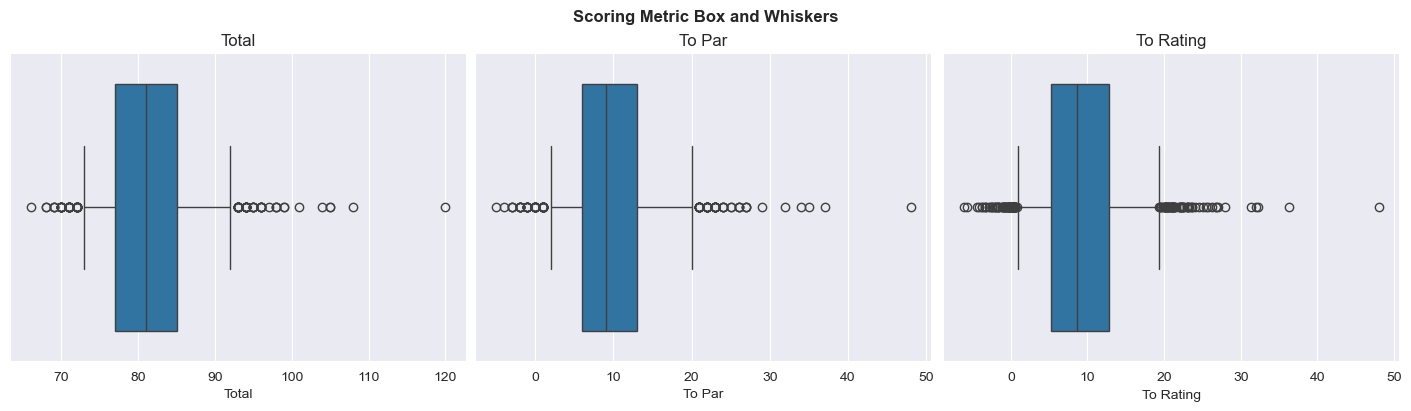

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), layout='constrained')

fig.suptitle('Scoring Metric Box and Whiskers', fontweight='bold')

for ax, col in enumerate(cols):
    sns.boxplot(scores[col], ax=axs[ax], orient='h', whis=[5,95])
    axs[ax].set_title(col);

Now, if we wanted to do a "quick and dirty" analysis, one could say "well I know the typical qualifying rate is somewhere around 20%, meaning I just need to be in the top 20% of my qualifier, a score of about 76, and I should qualify". On the surface, this looks like a fairly competent argument; however, as the visuals below show, not all 76s are created equal.

Many players who shot a 76 found themselves outside of qualification and in some cases, outside of alternate status as well. Including the author after three putting the final hole for double bogey at Toronto GC in 2025! Meanwhile, some players qualified while shooting a score noticeably higher than 76, including 21 scores of 78 or above.

These sort of nuances are what highlight the need for a more in-depth approach and where predictive modelling can get a better pulse on how other factors can effect the "competitiveness" of a score.

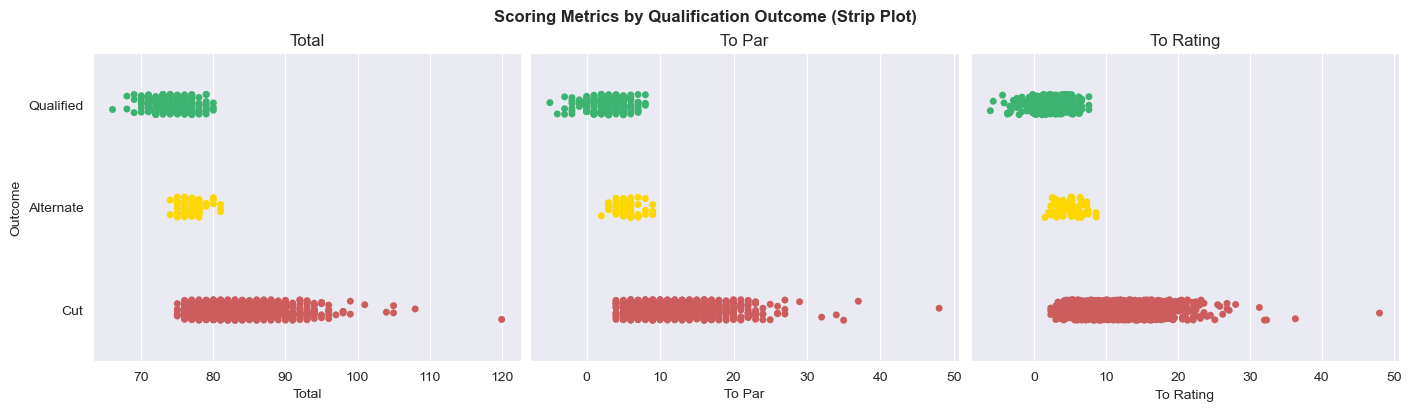

In [20]:
palette = {'Qualified': 'mediumseagreen', 'Alternate': 'gold', 'Cut':'indianred'}

fig, axs = plt.subplots(1, 3, figsize=(14, 4), layout='constrained', sharey=True)
fig.suptitle('Scoring Metrics by Qualification Outcome (Strip Plot)', fontweight='bold')

for ax, col in enumerate(cols):
    sns.stripplot(scores, y='Outcome', x=col, hue='Outcome', palette=palette, orient='h', ax=axs[ax])
    axs[ax].set_title(col);

The visuals below highlight the distributions stratified on outcome, with median total score for qualifiers being 74, equivalent to +3 (vs. par) or +2 (vs. Course Rating). While the median is a valuable insight, it is once again interesting to observe how high some of the outlier qualifying scores are relative to the alternate and cut distributions, and how some individuals with low scores were "unlucky".

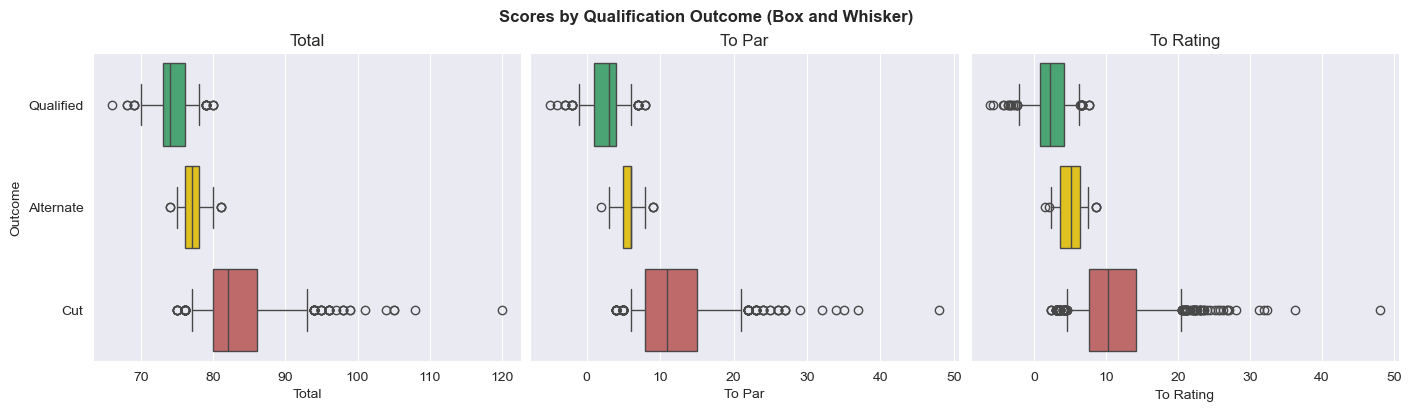

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), layout='constrained', sharey=True)
fig.suptitle('Scores by Qualification Outcome (Box and Whisker)', fontweight='bold')

for ax, col in enumerate(cols):
    sns.boxplot(scores, x=col, y='Outcome', hue='Outcome', orient='h', palette=palette, whis=[5,95], ax=axs[ax])
    axs[ax].set_title(col);

#### Regional Analysis
Going into this analysis, I was interested in how scores would vary based on region. My initial concern was the potential for "venue shopping", where golfers may drive to a site much further and potentially more "remote" from where they live in the hopes of experiencing an "easier" qualifying scenario.

Thankfully, based on the visuals below, competitive parity seems to be quite strong across regions! 

For example, relative to par (second visual), three of the four regions have the same median qualifying score of +3, with the remaining region (West) only slightly outperforming the others at +2. When looking on a more relative basis using score to Course Rating, parity falters slightly, with medians ranging from +1.4 to +3.3; however, all region's boxes (25th to 75th percentile) overlap demonstrating some relative similarities. So, while lower scores relative to standardized Course Rating may signify some regions having stronger relative fields, to be concerned with parity, I would need to see a greater discrepancy in qualifying scores. Helpfully, our predictive modelling with also provide statistically-backed guidance on whether region plays a part in qualification chances.

Importantly, I believe Golf Ontario's current [qualifying spot policy](https://gao.bluegolf.com/bluegolfw/gao/mo/AQ_Spots_Explained.htm) has a large part to play in their parity success. By providing more qualifying spots to larger, and therefore more competitive fields, the ability to qualify rests more on your ability to compete than the region in which you choose to qualify in, and its relative popularity.

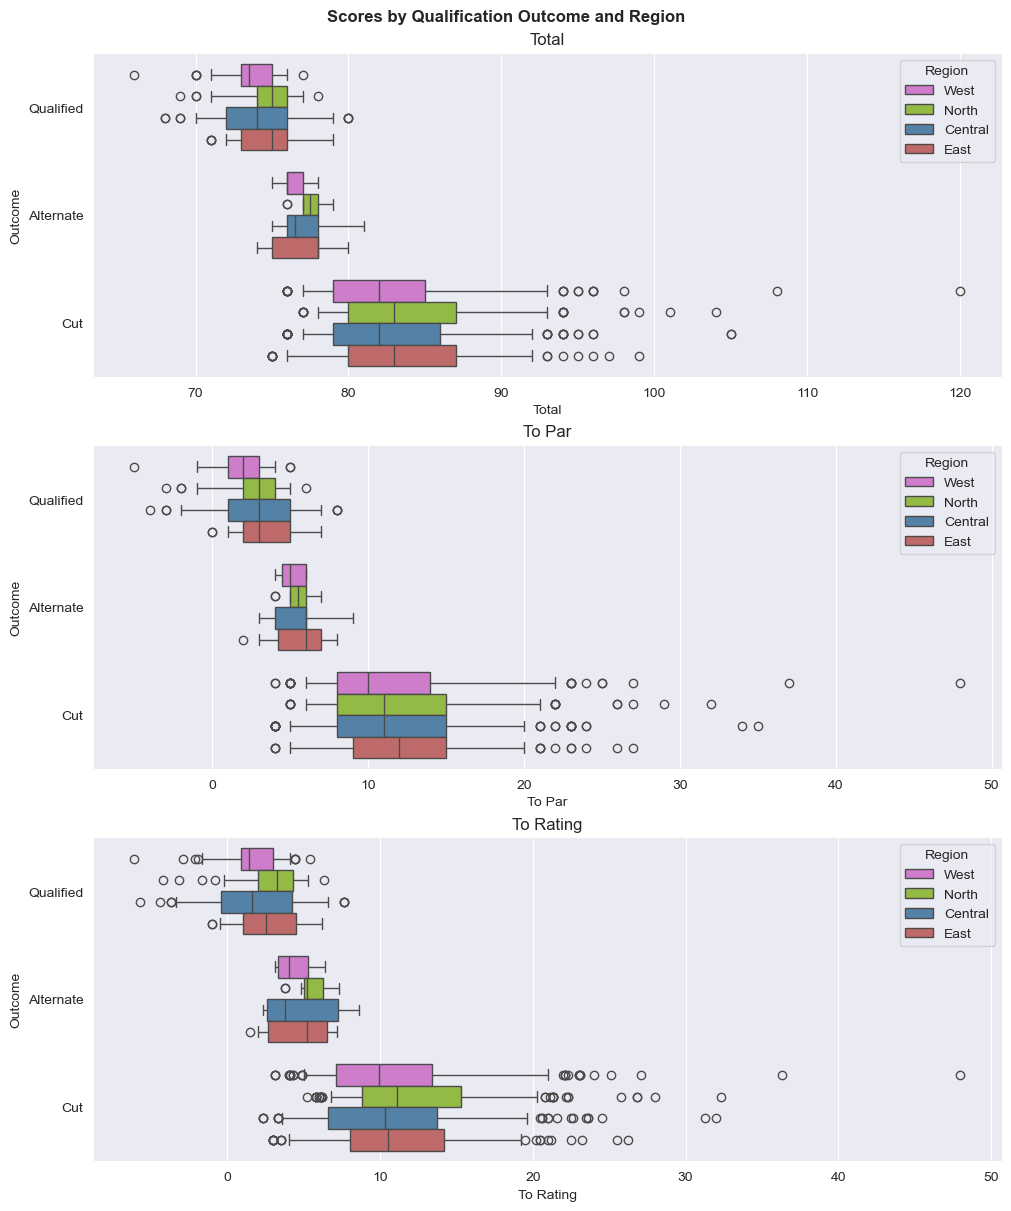

In [22]:
palette = {'West': 'orchid', 'North': 'yellowgreen', 'Central':'steelblue', 'East':'indianred'}

fig, axs = plt.subplots(3, 1, figsize=(10, 12), layout='constrained')

fig.suptitle('Scores by Qualification Outcome and Region', fontweight='bold') 

cols = ['Total', 'To Par', 'To Rating']

for ax, col in enumerate(cols):
    sns.boxplot(scores, x=col, y='Outcome', hue='Region', orient='h', whis=[5,95], ax=axs[ax], palette=palette)
    axs[ax].set_title(col);

**Now that we have a strong understanding of our data, we will attempt to predict whether a player qualified based on these factors.**

## Methodology and Modelling

### Methodology

#### Logistic Regression Primer

For this analysis, we are concerned with a binary, yes or no (1 or 0), outcome; did a player qualify or not. This type of structure is ideal for the use of Logistic Regression, a supervised machine learning classification algorithm that **provides probabilities of some event occurring based on certain factors**. I have attempted to provide a high-level understanding of how the algorithm works and what it means below, but for a more detailed look on Logistic Regression, feel free to check out this helpful [article from IBM](https://www.ibm.com/think/topics/logistic-regression) or this [informative (and fun!) YouTube tutorial](https://www.youtube.com/watch?v=yIYKR4sgzI8) from John Starmer of StatQuest.

A key benefit of Logistic Regression compared to other classification algorithms is its **interpretability**. While other algorithms may have higher accuracy, they act as more of a "black box", whereby one is unsure how the algorithm arrived at its conclusion. Comparatively, Logistic Regression provides a clean and interpretable output of the significance and impact of each variable on the outcome - something of high importance in this analysis. 

Without getting too technical, to arrive at probability values between 0 and 1, Logistic Regression transforms the input variables using a sigmoid transformation:

$$
P(Y = 1 \mid X) = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p}}{1 + e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p}}
$$

**In simpler terms, this equation says:** The probability of some event occuring (Y = 1) given some set of variable values (X) is equal to $e$ raised to the power of a linear equation of an intercept ($\beta_0$), and our variables ($x$'s) multiplied by their calculated coefficients ($\beta$'s), divided by 1 + the same equation.

To get the equation into a linear format where we can see the individual impact of a one-unit increase in a given variable, similar to a linear regression, further transformations are performed to arrive at the following:

$$
\log\left(\frac{P(Y=1 \mid X)}{1 - P(Y=1 \mid X)}\right)
= \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p
$$

Now, while this may look ugly, it just means that for a one-unit increase in variable $x_1$, we would expect the **log odds**, not the probability, to increase by $\beta_1$, **holding all other $x$ values equal**. Since the "log odds" isn't the most intuitive metric, we can exponentiate each side (raise $e$ to the power of each side) to get the **odds ratio**, an indication of how much more likely some event is to occur than not. Using some [exponentiation laws](https://www.cuemath.com/algebra/exponent-rules/), namely the product rule, in tandem with this transformation, we can then say a one-unit increase in variable $x_1$ would lead to a change in the odds of some event occuring by **a factor of $\beta_1$**, all else equal.

$$
\frac{P(Y=1 \mid X)}{1 - P(Y=1 \mid X)}
= e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p}
= e^{\beta_0} * e^{\beta_1 x_1} * e^{\beta_2 x_2} * \cdots * e^{\beta_p x_p}
$$

With a base understanding in Logistic Regression, the Qualified variable is now converted to a binary, yes or no (1 or 0), variable.

In [23]:
# Make 'Outcome' binary response variable
scores['Qualified'] = (scores['Outcome'] == 'Qualified').astype(int)
scores

,Pos.,To Par,Total,Outcome,Event ID,Qualifier Course,Date,Rating,Slope,Qualifying Rate (%),Weather Severity,Region,To Rating,Qualified
0,1,-1,71,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,-0.6,1
1,2,0,72,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,0.4,1
2,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4,1
3,3,1,73,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,1.4,1
4,5,3,75,Qualified,1,Sarnia G&CC,2025-04-29,71.6,127,22.222222,Medium,West,3.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,CUT,14,86,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,14.2,0
1410,CUT,15,87,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,15.2,0
1411,CUT,15,87,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,15.2,0
1412,CUT,18,90,Cut,25,Idylwylde G&CC,2023-06-10,71.8,135,13.513514,Medium,North,18.2,0


#### Quasi-Separation Discussion
If we try to run our Logistic Regression on the data as is, we will experience a phenomenon known as "Quasi-Complete Separation". This means one of our predictor variables almost perfectly separates the outcome variable (i.e. qualifying). In our scenario, this predictor is the score to par / score to rating variable. 

Again, to keep it high-level, the issue in our scenario is that for very low scores, such as multiple shots under par, the probability of qualifying has historically been 100%. Similarly, those who have shot exceedingly high scores have historically had a 0% probability of qualifying. Because of this clear separation, our algorithm tries to push coefficients to $\pm \infty$ to align with these scenarios, making prediction and inference unstable.

This is a key concept when it comes to answering this analysis' main question of "what do I need to shoot to qualify?". 

Specifically, history has shown that:
* The probability of qualifying with a score of par (E) or better (-1, -2, etc.) is **100%** (green-shaded region below).
* The probability of qualifying with a score above +10 is **0%** (red-shaded region).

Because of this, we are much more concerned with predicting the likelihood of those players who are on the margins; those who haven't shot a score exceptional enough to guarantee qualification, but one that certainly hasn't removed them from consideration altogether.

**Explicitly, our Logistic Regression model will calculate the probability of qualifying for players who have shot between +1 and +10 relative to i) par and ii) course rating (yellow region), with a unique model for each scoring metric.**

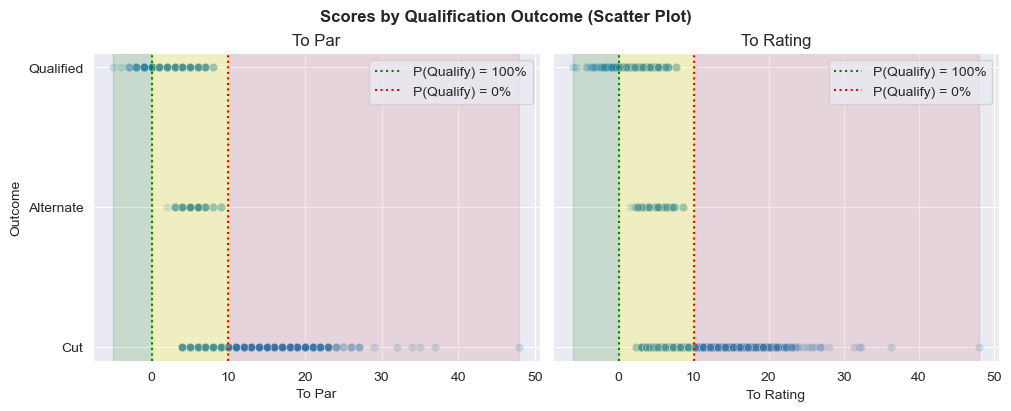

In [24]:
# Quasi-Separation under-par, +10 or worse
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained', sharey=True)
fig.suptitle('Scores by Qualification Outcome (Scatter Plot)', fontweight='bold')

for ax, col in enumerate(cols[1:]):
    sns.scatterplot(x=col, y='Outcome', data=scores, alpha=0.2, ax=axs[ax])
    axs[ax].set_title(col)
    axs[ax].axvline(0, ls=":", c='green', label='P(Qualify) = 100%')
    axs[ax].axvspan(scores[col].min(), 0, alpha=0.15, color='green')
    axs[ax].axvline(10, ls=":", c='red', label='P(Qualify) = 0%')
    axs[ax].axvspan(10, scores[col].max(), alpha=0.15, color='indianred')
    axs[ax].axvspan(0, 10, alpha=0.2, color='yellow')
    axs[ax].legend();

In [25]:
# Create subsets
tp_mid_scores = scores[scores['To Par'].between(1,10)]
tr_mid_scores = scores[scores['To Rating'].between(1,10)]

### Modelling

The first steps in modelling are to, i) decide which variables to include, and ii) split the data into two subsets; one to fit and train the model (i.e., get our esimated coefficients $\beta$'s), and another to test this trained model on data the model hasn't seen already. 

#### Score To Par

With most players using par as a benchmark rather than score relative to course rating, the first model will use this as its main scoring metric. Other variables to be included are course rating, weather severity, and qualifier region. Importantly, this and the following model do not consider factors such as field strength variance, weather randomness, or the impact of pressure on scoring.

##### Model Development and Output Discussion

From a technical perspective, I have **opted for [sum encoding](https://vasishth.github.io/Freq_CogSci/sum-coding.html) rather than one-hot encoding** to allow for more general interpretation. Sum encoding displays the variance from an "average" whereas one-hot displays the variance from some pre-determined baseline category. For example, instead of the Weather Severity coefficients being the difference compared to the medium scenario, it is the difference compared to the average across all values - much more applicable for this analysis. To assess performance, sklearn's default 75/25 training to testing split was used.

In [26]:
# Create design matrices and training and test data
y, X = patsy.dmatrices('Qualified ~ Q("To Par") + Rating + C(Q("Weather Severity"), Sum) + C(Region, Sum)', data=tp_mid_scores, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

As shown in the model summary below, **Region is statistically insignificant**, meaning **the region in which you opt to qualify does not have a statistical significance on your likelihood of doing so, holding all other variables equal**. This provides further support for our claim of strong competitive parity across regions.

In [27]:
# Instantiate and fit a logistic model to our training data
topar_logit_model = sm.Logit(y_train, X_train).fit()
topar_logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.206653
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  611
Model:                          Logit   Df Residuals:                      603
Method:                           MLE   Df Model:                            7
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.6523
Time:                        18:42:29   Log-Likelihood:                -126.26
converged:                       True   LL-Null:                       -363.16
Covariance Type:            nonrobust   LLR p-value:                 3.445e-98
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -32.9243     17.101     -1.925      0.054     -66.441       0.592
C(Q("Weather Severity"), Sum)[S.High]     2.5896      0.460      5.630      0.000       1.688       3.491
C(Q("Weather Severity"), Sum)[S.Low]     -2.0449      0.326     -6.265      0.000      -2.685      -1.405
C(Region, Sum)[S.Central]                 0.4480      0.305      1.469      0.142      -0.150       1.046
C(Region, Sum)[S.East]                   -0.0488      0.321     -0.152      0.879      -0.678       0.580
C(Region, Sum)[S.North]                   0.6543      0.286      2.288      0.022       0.094       1.215
Q("To Par")                              -1.6237      0.153    -10.593      0.000      -1.924      -1.323
Rating                                    0.5766      0.239      2.408      0.016       0.107       1.046
=========================================================================================================
"""

In [28]:
# Re-run with region removed.
y, X = patsy.dmatrices('Qualified ~ Q("To Par") + Rating + C(Q("Weather Severity"), Sum)', data=tp_mid_scores, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

After re-running the model with Region removed, we now have three main variables considered, Weather Severity, Score to Par, and Course Rating, with all being statistically significant.

As mentioned previously, we can interpret these base coefficients as the **impact on the log-odds with a one-unit change of said variable, holding all others equal**. For instance, a one-unit increase in a player's score to par reduces their log-odds of qualifying by 1.51. In the case of our categorical Weather Severity variable, a "one-unit increase" simply means this event occured. As an example, if weather severity was considered "Low", the log-odds of qualifying were reduced by 1.71, meaning a player **shooting an equal score** at a Low-Severity qualifier would see a reduction of 1.71 to their log-odds of qualifying compared to an "average" weather day.

Understandably, log-odds aren't the easiest to interpret, so instead we can observe each variable exponentiated, with each showing the **factor increase** of a one-unit increase to that variable. For example, using the same Low-Severity weather scenario, a player's odds of qualifying are increased by a factor of 0.18. Understanding this figure is less than 1, this means the odds of them qualifying is multiplied by a factor of 18% - in other words a reduction in likelilhood of 82%! Meanwhile, a player shooting the same score at a High-Severity event would see their odds increase by a factor of 9.09, or more than 800%! This output shows the clear impact that weather can, and has had on historical qualifying scores.

Most importantly, and what we will use to calculate the probability of qualifying shortly, a one-shot increase in a player's score relative to par leads to a reduction in their odds of qualifying by 78% (again, this is the same as saying it has been multiplied by a factor of 0.22). Said another way, **each additional stroke to par reduces a player's odds of qualifying by an additional 78%**.

*Note: The coefficient for Medium Weather Severity is found by taking the negative sum of the other Weather Severity coefficients (as per sum encoding methodology).*

In [29]:
topar_logit_model2 = sm.Logit(y_train, X_train).fit()
topar_logit_model2.summary()

Optimization terminated successfully.
         Current function value: 0.220099
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  611
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                            4
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.6297
Time:                        18:42:29   Log-Likelihood:                -134.48
converged:                       True   LL-Null:                       -363.16
Covariance Type:            nonrobust   LLR p-value:                 1.114e-97
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -34.0988     15.923     -2.141      0.032     -65.308      -2.890
C(Q("Weather Severity"), Sum)[S.High]     2.2070      0.412      5.354      0.000       1.399       3.015
C(Q("Weather Severity"), Sum)[S.Low]     -1.7134      0.297     -5.776      0.000      -2.295      -1.132
Q("To Par")                              -1.5092      0.139    -10.832      0.000      -1.782      -1.236
Rating                                    0.5834      0.223      2.612      0.009       0.146       1.021
=========================================================================================================
"""

In [30]:
medium_severity_coef = -(topar_logit_model2.params.iloc[1] + topar_logit_model2.params.iloc[2])
new_entry = pd.Series([medium_severity_coef], index=['C(Q("Weather Severity"), Sum)[S.Medium]'])

# Concatenate the original Series and the new entry
topar_logit_model2.params = pd.concat([topar_logit_model2.params, new_entry])

custom_order = ['Intercept', 'C(Q("Weather Severity"), Sum)[S.Low]', 'C(Q("Weather Severity"), Sum)[S.Medium]', 'C(Q("Weather Severity"), Sum)[S.High]', 
                'Q("To Par")', "Rating"]
to_par_coefs = pd.DataFrame(topar_logit_model2.params).reindex(custom_order)
to_par_coefs.columns = ['Coefficient']

to_par_coefs = to_par_coefs.rename(index={'C(Q("Weather Severity"), Sum)[S.Low]': 'Weather Severity - Low', 
                            'C(Q("Weather Severity"), Sum)[S.Medium]': 'Weather Severity - Medium',
                            'C(Q("Weather Severity"), Sum)[S.High]': 'Weather Severity - High',
                            'Q("To Par")': 'To Par'})

# Exponentiate coefficients
to_par_coefs['Exponentiated'] = np.exp(to_par_coefs['Coefficient'])
to_par_coefs['Exponentiated'] = to_par_coefs['Exponentiated'].apply(np.format_float_positional, precision=3)
to_par_coefs

,Coefficient,Exponentiated
Intercept,-34.098821,0.000
Weather Severity - Low,-1.713364,0.180
Weather Severity - Medium,-0.493608,0.610
Weather Severity - High,2.206972,9.088
To Par,-1.509226,0.221
Rating,0.583376,1.792


##### Model Performance

Using these coefficients and some transformations, the predicted probability of qualification for each player can be calculated. Using these predicted probabilities, records are classified as "Did Not Qualify" (0) or "Qualified" (1). Records with probabilities above a certain threshold, this iteration used 0.5, were classified as 1s, while those below were classified as 0s. To assess model performance, we then look at how accurate the model was at classifying true qualifiers and true non-qualifiers on data it had not already seen (test data). 

The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) below shows a model with 0.5 threshold correctly predicts qualification 87% of the time. Understanding roughly 80% of players don't qualify based on historical qualifying rates, a "Naive" or "Dummy" model that classifies all players as Did Not Qualify (0) would be correct 80% of the time; however, its Sensitvity (ability to detect true positives) would be 0%, which isn't beneficial in this scenario. With an overall accuracy of 87%, and a Sensitivity of 74% combined with a Specificity (ability to identify non-qualifiers) of 93%, I am confident this model outperforms a "Naive" model.

Overall Accuracy: 87.3%
Sensitivity: 74.2%
Specificity: 93.0%


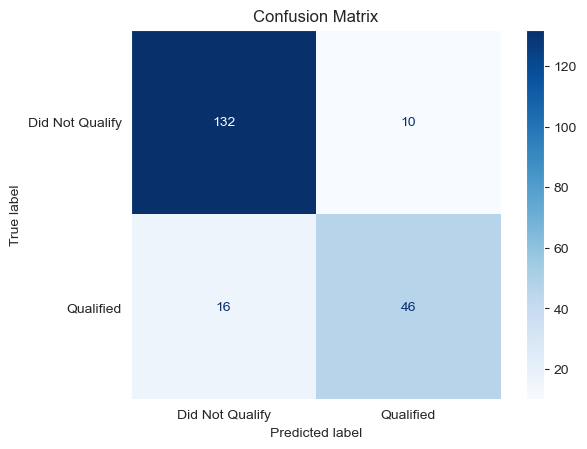

In [31]:
# Provide the predicted probabilities from our trained model on our test data.
y_pred_probs = topar_logit_model2.predict(X_test)
labels = y_pred_probs >0.5

# Create confusion_matrix object
cm = confusion_matrix(y_test['Qualified'], labels)

print(f'Overall Accuracy: {((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))*100:.1f}%')
print(f'Sensitivity: {cm[1][1] / (cm[1][0] + cm[1][1])*100:.1f}%')
print(f'Specificity: {cm[0][0] / (cm[0][0] + cm[0][1])*100:.1f}%')

# 3. Visualize the confusion matrix with labels using ConfusionMatrixDisplay
# Rows typically represent actual values, columns represent predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Qualify", "Qualified"])
disp.plot(cmap=plt.cm.Blues) # Use a colormap for better visualization
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

To improve model performance, we can tune the threshold parameter. Importantly, a change in threshold will have an inverse impact on Sensitivity versus Specificity. For example, if we only assign players with a high predicted probability (threshold of 80%), the likelihood we incorrectly predict they qualified will be lower (False Positive Rate); however, we may miss some players who did in fact qualify because our model's predicted probability did not meet this higher threshold (True Positive Rate). 

To understand this tradeoff across all thresholds, an [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is used. The ideal threshold is one that balances the True Positive and False Positive Rates well - the highest left point on the ROC curve. The AUC value is the calculated area below this curve, with a higher value indicating a better performing model.

The Youden's J statistic is a process that identifies the optimal threshold by maximizing Sensitivity and Specificity. With this model, the optimal threshold is approximately 0.32. When using the Youden's J statistic as the threshold, the model's overall accuracy increases by less than a percent, but experiences material improvements to Sensitivity (+12%) with minor reductions to Specificity (-4%).

Optimal Threshold (Youden's J): 0.32


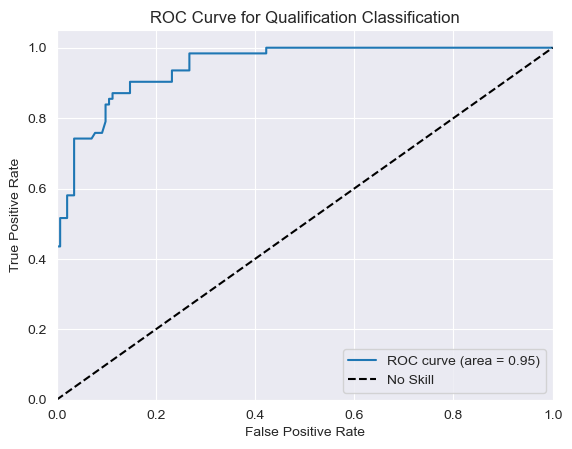

In [32]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) 
roc_auc = auc(fpr, tpr)

# 2. Calculate Youden's J statistic
# Specificity is 1 - fpr
J = tpr - fpr

# 3. Find the index of the maximum J value
optimal_idx = np.argmax(J)

# 4. Retrieve the optimal threshold
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.2f}")

# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Qualification Classification')
plt.legend();

Overall Accuracy: 87.7%
Sensitivity: 85.5%
Specificity: 88.7%


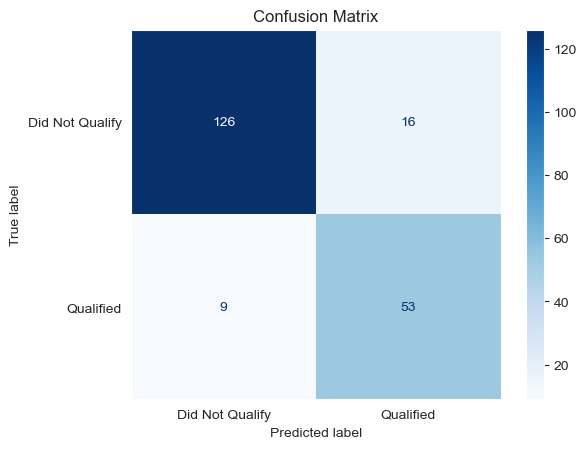

In [33]:
labels = y_pred_probs >0.32
cm = confusion_matrix(y_test['Qualified'], labels)

print(f'Overall Accuracy: {((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))*100:.1f}%')
print(f'Sensitivity: {cm[1][1] / (cm[1][0] + cm[1][1])*100:.1f}%')
print(f'Specificity: {cm[0][0] / (cm[0][0] + cm[0][1])*100:.1f}%')

# 3. Visualize the confusion matrix with labels using ConfusionMatrixDisplay
# Rows typically represent actual values, columns represent predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Qualify", "Qualified"])
disp.plot(cmap=plt.cm.Blues) # Use a colormap for better visualization
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

**Overall, this model demonstrates high accuracy across the three main metrics discussed (Overall, Sensitivity, and Specificity), and provides confidence in it's ability to assess qualification likelihoods.**

#### Score to Course Rating

While many golfers may use score to par as a benchmark, a model using score to Course Rating may provide a cleaner output by standardizing score across course difficulty. 

##### Model Development and Output Discussion

Since score to Course Rating standardizes across course difficulty and Region was already deemed statistically insignificant, the only other variable considered for this model was Weather Severity.

The coefficients in this model follow a similar trend as the "To Par" model, with the odds of qualifying improving inversely with weather severity. With that being said, this model's coefficients are less extreme, especially the intercept, and have smaller standard errors, demonstrating more stability. With this additional stability, **this model is likely more useful for extrapolation than the previous model.**

In terms of specific findings, each coefficient has the following affect on the odds of qualifying:
- **Low Severity:** Reduced by factor of 0.67
- **Medium Severity:** Increased by a factor of 1.02
- **High Severity:** Increased by a factor of 2.97
- **Score To Rating:** Reduced by a factor of 0.64

In [34]:
y, X = patsy.dmatrices('Qualified ~ Q("To Rating") + C(Q("Weather Severity"), Sum)', data=tr_mid_scores, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

# Instantiate and fit a logistic model to our training data
torating_logit_model = sm.Logit(y_train, X_train).fit()
torating_logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.301229
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  585
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            3
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                  0.4657
Time:                        18:42:30   Log-Likelihood:                -176.22
converged:                       True   LL-Null:                       -329.79
Covariance Type:            nonrobust   LLR p-value:                 2.839e-66
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 4.3791      0.461      9.498      0.000       3.476       5.283
C(Q("Weather Severity"), Sum)[S.High]     1.0896      0.340      3.201      0.001       0.422       1.757
C(Q("Weather Severity"), Sum)[S.Low]     -1.1078      0.235     -4.718      0.000      -1.568      -0.648
Q("To Rating")                           -1.0226      0.089    -11.508      0.000      -1.197      -0.848
=========================================================================================================
"""

In [35]:
medium_severity_coef = -(torating_logit_model.params.iloc[1] + torating_logit_model.params.iloc[2])
new_entry = pd.Series([medium_severity_coef], index=['C(Q("Weather Severity"), Sum)[S.Medium]'])

# Concatenate the original Series and the new entry
torating_logit_model.params = pd.concat([torating_logit_model.params, new_entry])

custom_order = ['Intercept', 'C(Q("Weather Severity"), Sum)[S.Low]', 'C(Q("Weather Severity"), Sum)[S.Medium]', 'C(Q("Weather Severity"), Sum)[S.High]', 
                'Q("To Rating")']

to_rating_coefs = pd.DataFrame(torating_logit_model.params).reindex(custom_order)
to_rating_coefs.columns = ['Coefficient']

to_rating_coefs = to_rating_coefs.rename(index={'C(Q("Weather Severity"), Sum)[S.Low]': 'Weather Severity - Low', 
                            'C(Q("Weather Severity"), Sum)[S.Medium]': 'Weather Severity - Medium',
                            'C(Q("Weather Severity"), Sum)[S.High]': 'Weather Severity - High',
                            'Q("To Rating")': 'To Rating'})

# Exponentiate coefficients
to_rating_coefs['Exponentiated'] = np.exp(to_rating_coefs['Coefficient'])
to_rating_coefs['Exponentiated'] = to_rating_coefs['Exponentiated'].apply(np.format_float_positional, precision=3)
to_rating_coefs

,Coefficient,Exponentiated
Intercept,4.379143,79.77
Weather Severity - Low,-1.107798,0.330
Weather Severity - Medium,0.018193,1.018
Weather Severity - High,1.089605,2.973
To Rating,-1.022557,0.36


##### Model Performance

When assessing this model's performance, overall accuracy was roughly 85%, while Sensitivity was 59% and Specificity was 95%. 

Overall Accuracy: 84.6%
Sensitivity: 58.9%
Specificity: 95.0%


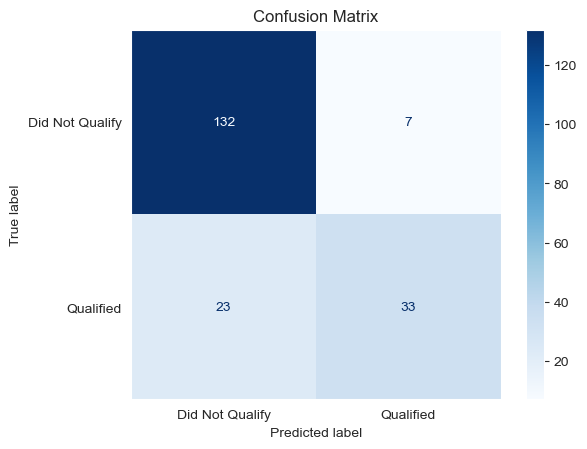

In [36]:
y_pred_probs = torating_logit_model.predict(X_test)
labels = y_pred_probs > 0.5

cm = confusion_matrix(y_test['Qualified'], labels)

print(f'Overall Accuracy: {((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))*100:.1f}%')
print(f'Sensitivity: {cm[1][1] / (cm[1][0] + cm[1][1])*100:.1f}%')
print(f'Specificity: {cm[0][0] / (cm[0][0] + cm[0][1])*100:.1f}%')

# 3. Visualize the confusion matrix with labels using ConfusionMatrixDisplay
# Rows typically represent actual values, columns represent predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Qualify", "Qualified"])
disp.plot(cmap=plt.cm.Blues) # Use a colormap for better visualization
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Deriving Youden's J statistic provided an optimal threshold of 0.21, which led to similar overall accuracy, a significant improvement in Sensitivity (+30%), and moderate decreases in Specificity (-11%).

**Similar to the "To Par" model, this model performs well and can be used confidently, even more so than the prior model, to predict probabilities.**

Optimal Threshold (Youden's J): 0.21


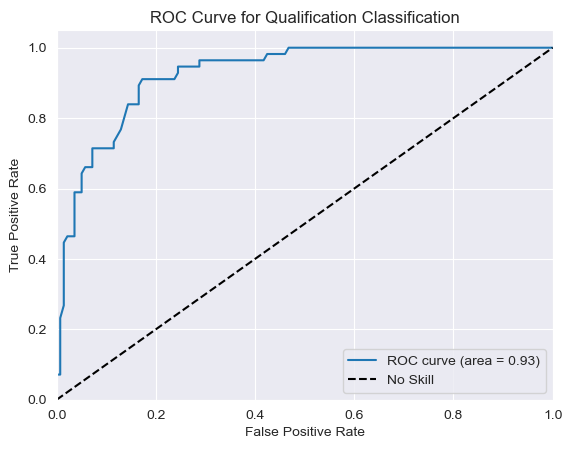

In [37]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) 
roc_auc = auc(fpr, tpr)

# 2. Calculate Youden's J statistic
# Specificity is 1 - fpr
J = tpr - fpr

# 3. Find the index of the maximum J value
optimal_idx = np.argmax(J)

# 4. Retrieve the optimal threshold
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.2f}")

# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Qualification Classification')
plt.legend();

Overall Accuracy: 85.1%
Sensitivity: 89.3%
Specificity: 83.5%


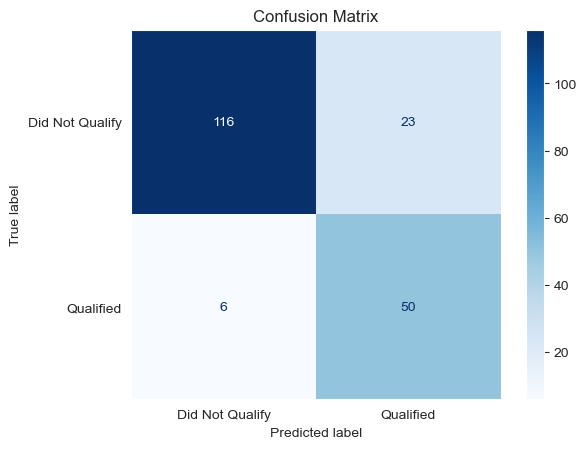

In [38]:
labels = y_pred_probs >0.21

cm = confusion_matrix(y_test['Qualified'], labels)
print(f'Overall Accuracy: {((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))*100:.1f}%')
print(f'Sensitivity: {cm[1][1] / (cm[1][0] + cm[1][1])*100:.1f}%')
print(f'Specificity: {cm[0][0] / (cm[0][0] + cm[0][1])*100:.1f}%')

# 3. Visualize the confusion matrix with labels using ConfusionMatrixDisplay
# Rows typically represent actual values, columns represent predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Qualify", "Qualified"])
disp.plot(cmap=plt.cm.Blues) # Use a colormap for better visualization
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

## How Score Impacts Qualification Likelihood

With two strong models, it is now possible to answer the main question of this analysis:

**"What does a player need to shoot to have a high chance of qualifying for the Ontario Men's Mid-Am?".**

To calculate how a player's chance of qualifying will vary based on changes in score, all one has to do is hold all other variable values constant, while changing the level of scoring for said model (score to par or score to Course Rating). With this, a predicted probability can be extracted for each score.

### Score to Par Results

The visual below demonstrates the change in probability based on score to par, holding weather severity constant and assuming a course rating value of 72, the median across all qualifiers studied.

**This visual is the answer to our question. It demonstrates the exact percentage difference in qualification likelihood for different scores to par.**

Some insights:
- Scores of +3 or better all had >95% chance of qualifying, while those with scores above +6 had a less than 7% chance.
- The sharpest decline in probability occurs between +4 and +6. This is the most "fragile" scoring range, where a single stroke meaningfully changes qualification chances. This two-shot difference leads to a 63% reduction in qualification likelihood.
- To have a 50/50 chance of qualifying, one must shoot between +5 and +6, on average.

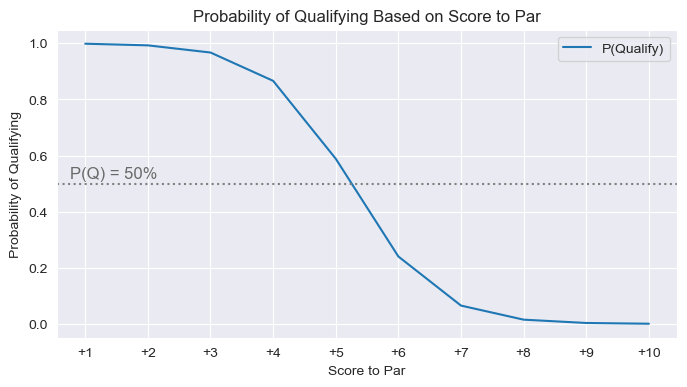

In [39]:
tp_intercept_coef = to_par_coefs.iloc[0,0]
tp_low_weather_coef = to_par_coefs.iloc[1,0]
tp_mid_weather_coef = to_par_coefs.iloc[2,0]
tp_high_weather_coef = to_par_coefs.iloc[3,0]
tp_to_par_coef = to_par_coefs.iloc[4,0]
tp_rating_coef = to_par_coefs.iloc[5,0]

to_par_scores = np.arange(1,11)
to_par_probs = []

# Average Severity
## Don't include the weather coefficients. This get's us the GRAND MEAN across all weather scenarios.
for score in to_par_scores:
    q_prob = np.exp((tp_intercept_coef + tp_to_par_coef*score + tp_rating_coef*72)) / (1+np.exp((tp_intercept_coef + tp_to_par_coef*score + tp_rating_coef*72)))
    to_par_probs.append(q_prob)

to_par_probs = pd.DataFrame(data={'P(Qualify)':to_par_probs},
                           index=[f'+{i}' for i in to_par_scores])

fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=to_par_probs, x=to_par_probs.index, y="P(Qualify)", ax=ax, label='P(Qualify)')
ax.set_xlabel('Score to Par')
ax.set_ylabel('Probability of Qualifying')
ax.set_title('Probability of Qualifying Based on Score to Par')
ax.text(x=-0.25, y=.52, s="P(Q) = 50%", fontsize=12, color='dimgrey')
ax.axhline(0.5, c='grey', ls=':');

With a Logistic Regression, we can also model out how the probabilities of qualification would change in the three different weather scenarios.

For example, while a score of +3 in a Low-Severity scenario has a predicted qualification probability of 84%, it is nearly ≥ 95% in Medium- and High-Severity scenarios. As score increases we see an even greater disparity in probabilities across weather scenarios. At +5, the probability of qualifying in Low-Severity is just 20% compared to a staggering 92% in High-Severity.

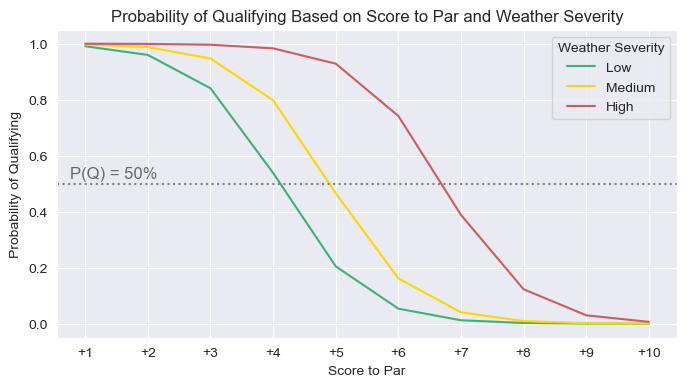

In [40]:
lowseverity_probs = []
medseverity_probs = []
highseverity_probs = []

## Assuming Rating of 72.0 
# Low Severity
for score in to_par_scores:
    q_prob = np.exp((tp_intercept_coef + tp_low_weather_coef + tp_to_par_coef*score + tp_rating_coef*72)) / (1+np.exp((tp_intercept_coef + tp_low_weather_coef + tp_to_par_coef*score + tp_rating_coef*72)))
    lowseverity_probs.append(q_prob)

# Medium Severity
for score in to_par_scores:
    q_prob = np.exp((tp_intercept_coef + tp_mid_weather_coef + tp_to_par_coef*score + tp_rating_coef*72)) / (1+np.exp((tp_intercept_coef + tp_mid_weather_coef + tp_to_par_coef*score + tp_rating_coef*72)))
    medseverity_probs.append(q_prob)

# High Severity
for score in to_par_scores:
    q_prob = np.exp((tp_intercept_coef + tp_high_weather_coef + tp_to_par_coef*score + tp_rating_coef*72)) / (1+np.exp((tp_intercept_coef + tp_high_weather_coef + tp_to_par_coef*score + tp_rating_coef*72)))
    highseverity_probs.append(q_prob)

df = {'Low': lowseverity_probs, 'Medium': medseverity_probs, 'High': highseverity_probs}
df = pd.DataFrame(df)
df['x'] = [f'+{i+1}' for i in df.index]

# reshape for seaborn
df_long = df.melt(id_vars="x", var_name="Weather Severity", value_name="Probability")

palette = {'Low': 'mediumseagreen', 'Medium': 'gold', 'High':'indianred'}

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=df_long, x="x", y="Probability", hue="Weather Severity", palette=palette, ax=ax)

# Set the corresponding custom labels
ax.set_xlabel('Score to Par')
ax.set_ylabel('Probability of Qualifying')
ax.set_title('Probability of Qualifying Based on Score to Par and Weather Severity')
ax.text(x=-0.25, y=.52, s="P(Q) = 50%", fontsize=12, color='dimgrey')
ax.axhline(0.5, c='grey', ls=':');

### Score to Course Rating Results

Now looking at the score to Course Rating model, we see similar insights:

- Scores within 2 strokes of Course Rating had a >90% chance of qualifying, while those with scores 7 strokes or above Course Rating had a less than 6% chance.
- The sharpest decline in probability occurs between +2.5 and +5.5. This difference of three shots, led to a 64% reduction in qualification likelihood.
- To have a 50/50 chance of qualifying, one must shoot between +4.0 and +4.5 relative to Course Rating, on average.

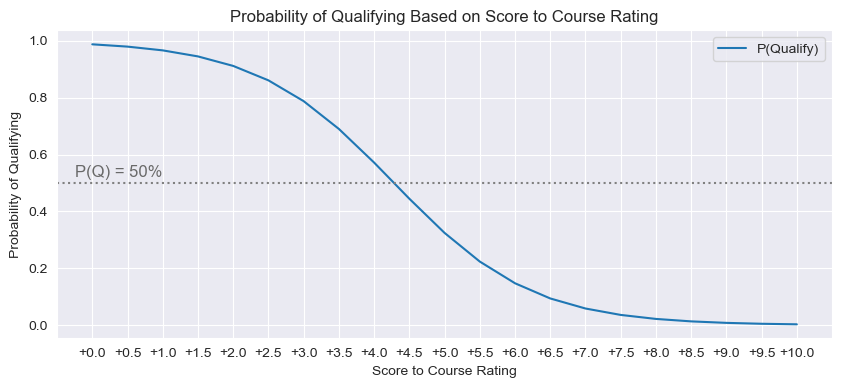

In [41]:
tr_intercept_coef = to_rating_coefs.iloc[0,0]
tr_low_weather_coef = to_rating_coefs.iloc[1,0]
tr_mid_weather_coef = to_rating_coefs.iloc[2,0]
tr_high_weather_coef = to_rating_coefs.iloc[3,0]
tr_to_rating_coef = to_rating_coefs.iloc[4,0]

to_rating_scores = np.arange(0, 10.5, 0.5)
to_rating_probs = []

# Average Severity
## Don't include the weather coefficients. This get's us the GRAND MEAN across all weather scenarios.
for score in to_rating_scores:
    q_prob = np.exp((tr_intercept_coef + tr_to_rating_coef*score)) / (1+np.exp((tr_intercept_coef + tr_to_rating_coef*score)))
    to_rating_probs.append(q_prob)

to_rating_probs = pd.DataFrame(data={'P(Qualify)':to_rating_probs},
                               index=[f'+{i}' for i in to_rating_scores])

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=to_rating_probs, x=to_rating_probs.index, y="P(Qualify)", ax=ax, label='P(Qualify)')
ax.set_xlabel('Score to Course Rating')
ax.set_ylabel('Probability of Qualifying')
ax.set_title('Probability of Qualifying Based on Score to Course Rating')
ax.text(x=-0.5, y=.52, s="P(Q) = 50%", fontsize=12, color='dimgrey')
ax.axhline(0.5, c='grey', ls=':');

When stratifying on weather severity, there again exists a significant difference in qualification probabilities. For example, in Low-Severity a score of +4 relative to course rating would have a predicted probability of just 31%. Comparatively, this same score in a Medium- or High-Severity scenario would have 58%, and 80% chance of qualifying, respectively; roughly 2-3x as likely.

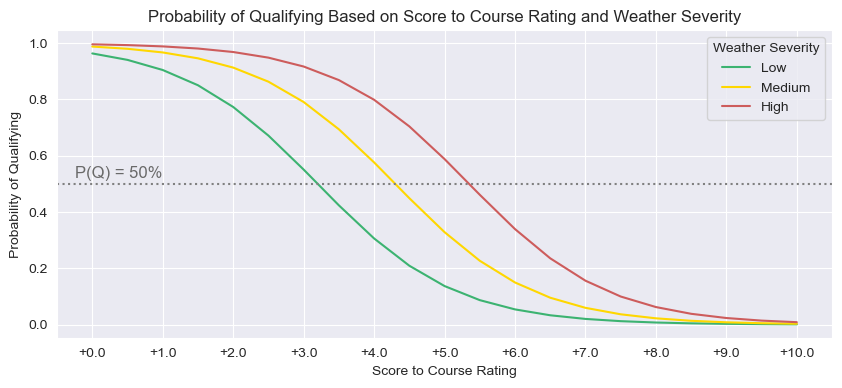

In [42]:
lowseverity_probs = []
medseverity_probs = []
highseverity_probs = []

## Don't need to assume rating because this is already considered.
# Low Severity
for score in to_rating_scores:
    q_prob = np.exp((tr_intercept_coef + tr_low_weather_coef + tr_to_rating_coef*score)) / (1+np.exp((tr_intercept_coef + tr_low_weather_coef + tr_to_rating_coef*score)))
    lowseverity_probs.append(q_prob)

# Medium Severity
for score in to_rating_scores:
    q_prob = np.exp((tr_intercept_coef + tr_mid_weather_coef + tr_to_rating_coef*score)) / (1+np.exp((tr_intercept_coef + tr_mid_weather_coef + tr_to_rating_coef*score)))
    medseverity_probs.append(q_prob)

# High Severity
for score in to_rating_scores:
    q_prob = np.exp((tr_intercept_coef + tr_high_weather_coef + tr_to_rating_coef*score)) / (1+np.exp((tr_intercept_coef + tr_high_weather_coef + tr_to_rating_coef*score)))
    highseverity_probs.append(q_prob)

df = {'Low': lowseverity_probs, 'Medium': medseverity_probs, 'High': highseverity_probs}
df = pd.DataFrame(df)
df['x'] = [f'+{i}' for i in to_rating_scores]

# reshape for seaborn
df_long = df.melt(id_vars="x", var_name="Weather Severity", value_name="Probability")

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.lineplot(data=df_long, x="x", y="Probability", hue="Weather Severity", palette=palette, ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(2))

# Set the corresponding custom labels
ax.set_xlabel('Score to Course Rating')
ax.set_ylabel('Probability of Qualifying')
ax.set_title('Probability of Qualifying Based on Score to Course Rating and Weather Severity')
ax.text(x=-0.5, y=.52, s="P(Q) = 50%", fontsize=12, color='dimgrey')
ax.axhline(0.5, c='grey', ls=':');

### Personal Example

As a fun exercise, we can look my two qualifying attempts for this championship and assess my likelihood of qualifying for each. Key data pertaining to both can be found below:

- **Attempt 1: Mystic GC (2024)**
    - Course Rating = 72.4
    - Weather Severity = High
    - Score to Par = +16
    - Score to Course Rating = +15.6
    - Result = Did Not Qualify
- **Attempt 2: Toronto GC (2025)**
    - Course Rating = 73.7
    - Weather Severity = Low
    - Score to Par = +6
    - Score to Course Rating = +2.3
    - Result = Did Not Qualify

Plugging this data into each model, the respective qualifying probabilities are as follows:
- **Attempt 1: Mystic GC (2024)**
    - To Par Model = 0%
    - To Course Rating Model = 0%
- **Attempt 2: Toronto GC (2025)**
    - To Par Model = 13%
    - To Course Rating Model = 72%

It is interesting to see such a variance in probabilities between models for the Toronto qualifiers. This discrepancy highlights why the "To Rating" model is a stronger model, even if it is slightly less intuitive. Although both models account for course difficulty, the "To Rating" model builds difficulty into the performance metric itself, while the "To Par" model applies difficulty as a secondary adjustment. This leads to different predictions when courses vary in how hard they play. In the Toronto example, the "To Par" model sees a score of +6, usually only 10% chance of qualifying in Low-Severity conditions, then tries to adjust the probability since Toronto has a higher Course Rating than all other qualifiers studied. Comparatively, the "To Rating" model sees a score of +2.3 relative to course rating, and assesses that this score typically has a good chance of qualifying. The "To Rating" model incorporates course difficulty from the beginning, whereas the "To Par" model makes a broader "average adjustment", in this case much smaller of an adjustment than the "To Rating" model.

## Limitations and Next Steps

### Limitations

Throughout this analysis, there were numerous checks for robustness and validity (use of training / test split, Naive model comparison, threshold tuning); however, any analysis will come with its limitations. The most prevalent in this analysis are as follows:

- **Limitation 1: Course-Specific Unobservables -**
This analysis does not fully capture course-specific setup decisions such as pin placements or firmness, which may influence scoring variability beyond what is reflected in course rating. While I did participate in two of these qualifiers and was able to opine on the conditions, I cannot say the same for the remaining 23 events.

- **Limitation 2: Binary Outcome Simplification -**
Qualification is only modeled as a binary outcome, which doesn't incorporate alternate positions.

- **Limitation 3: External Validity -**
Results are specific to the competitive structure and field strength of these qualifying events and may not generalize to other golf organizations or qualification formats.

- **Limitation 4: Interpretability vs. Optimality -**
Although score relative to course rating yields slightly stronger statistical performance, score relative to par may be more interpretable for players, representing a trade-off between predictive accuracy and practical usability.

### Next Steps

Understanding data science is an ever-evolving world, this analysis is no different. In terms of potential next steps and improvements, the following come to mind:

- **Inter-Championship Variances:** With similar qualification processes for nearly all of Golf Ontario's championships, this analysis could theoretically be run quite easily for all of them, especially using webscraping rather than Excel files. By doing so, one could observe any significant inter-championship variances or discrepencies, such as the comparative strength of qualifying fields, and adjust rules and policies accordingly.
- **Player Handicap Data:** With access to each player's handicap data, it would be possible to incorporate recent performance into the predicted qualification probabilities. For example, could looking at a player's last 10 rounds demonstrate a significant impact on their qualification likelihood? Additionally, incorporating handicap data might be a helpful way to reduce non-competitive golfers from entering a qualifier and taking the spot of a player with a more realistic chance.
- **Prior Qualification Performance:** By tracking player's individually, analysis could aim to answer the question of "Does past success predict future success? By how much?".
- **Multi-Outcome Model:** Instead of predicting just the probability of qualifying one could use a [Multinomial Logistic Regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to predict all three potential outcomes in a qualifier (qualified, alternate, and cut).
- **Intra-Round Probabilities:** Rather than observing probability of qualification based on a final score, a model could instead aim to predict qualification based on current position in a round. For example, if a player is +5 with 6 holes remaining, what is the probability they qualify?

If you made it all the way to the end, congratulations! I appreciate the interest and would love to hear your thoughts on this analysis.